In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/tmp/ipython-input-484597420.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])



Clustering Evaluation Results:
              silhouette  davies_bouldin  calinski_harabasz
KMeans          0.534705        0.566657        2416.045068
Hierarchical    0.518865        0.721248        2235.294800
GMM             0.111926        1.407630         655.948575
SOM             0.489982        1.103546        1074.302678

Cluster Profiles:

--- Cluster_KMeans ---
                   Recency   Frequency       Monetary  CancellationRate
Cluster_KMeans                                                         
0                40.614387    6.390861    2120.403529          0.023954
1               209.214953    1.990654    -784.365234          0.845336
2               238.973837    1.917636     513.071671          0.019990
3                 5.600000  139.000000  206931.732000          0.018723

--- Cluster_Hier ---
                 Recency   Frequency       Monetary  CancellationRate
Cluster_Hier                                                         
0               3.363636  142.3

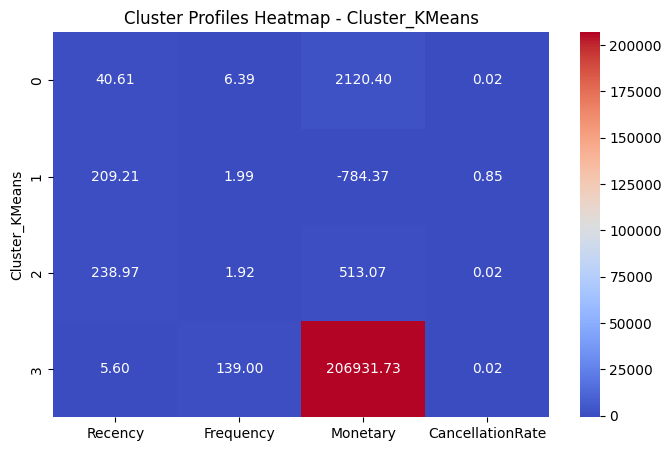

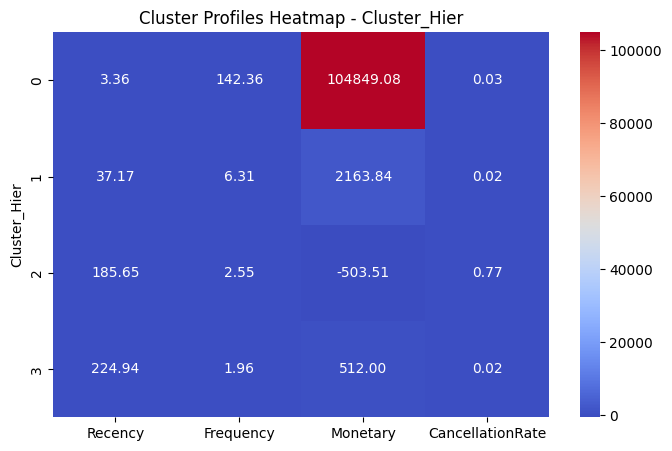

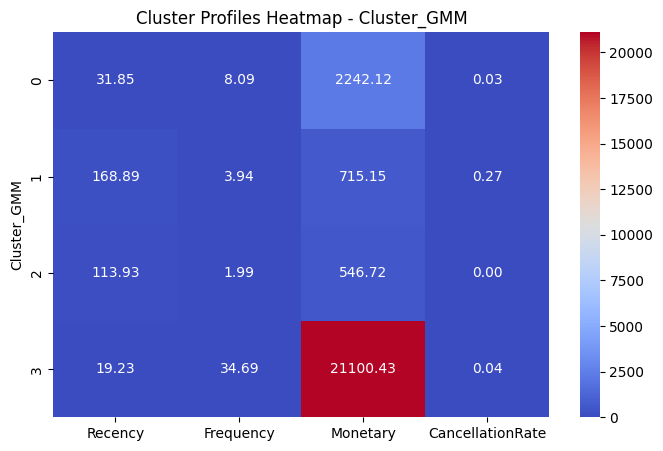

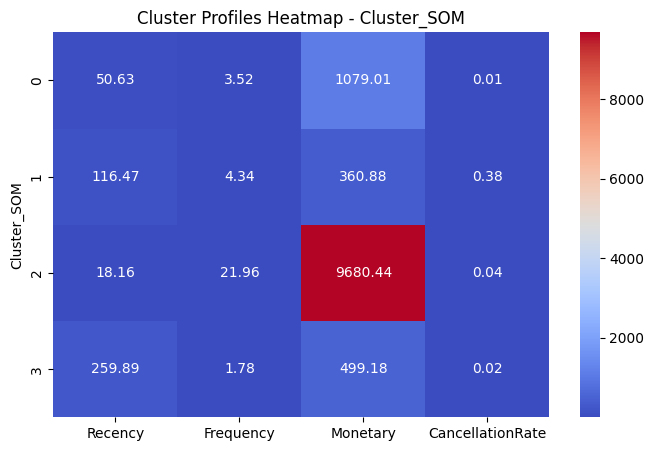

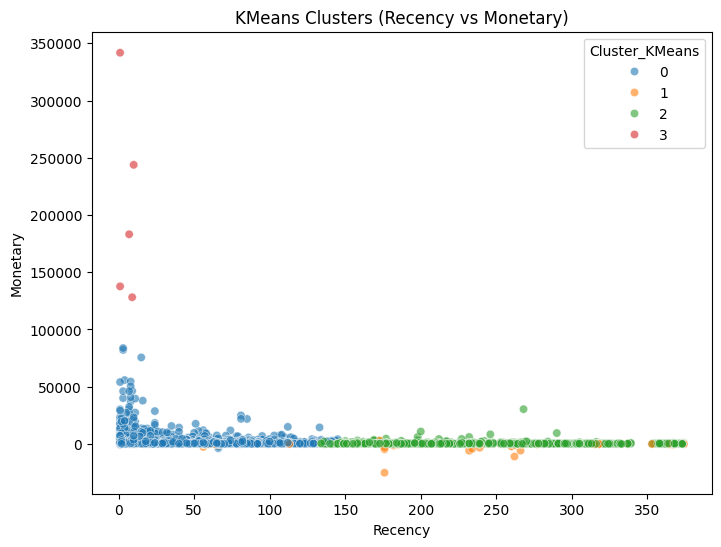

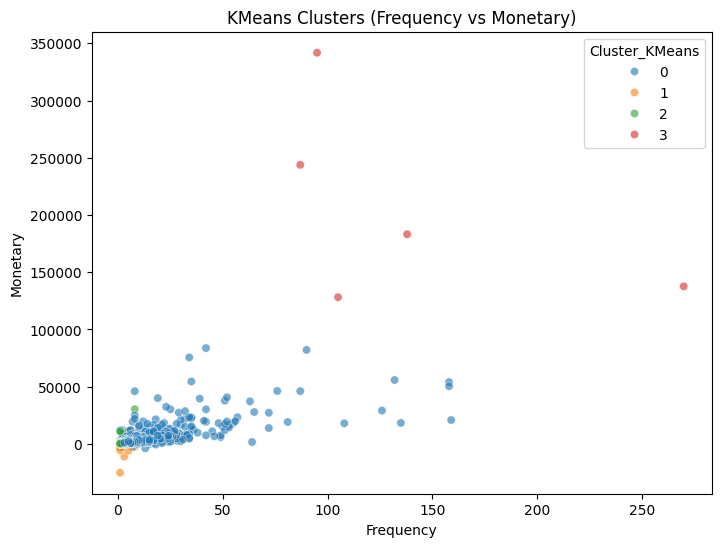

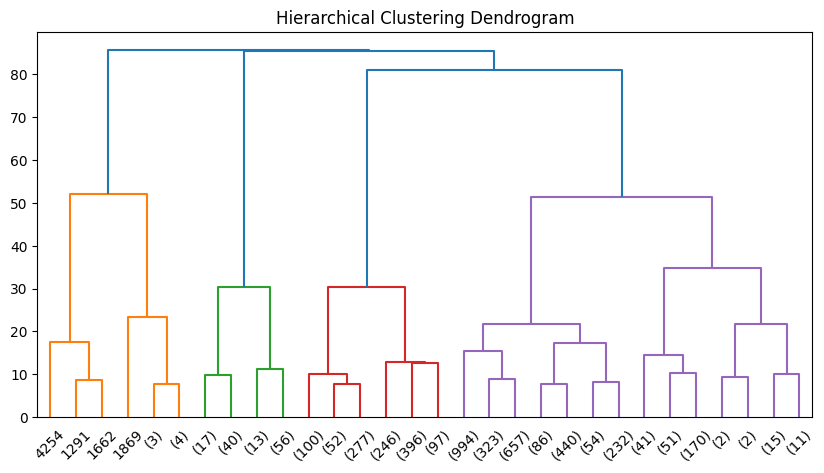

   CustomerID  Cluster_KMeans Cluster_KMeans_Name  Cluster_Hier  \
0     12346.0               0      Loyal Regulars             1   
1     12347.0               0      Loyal Regulars             1   
2     12348.0               0      Loyal Regulars             1   
3     12349.0               0      Loyal Regulars             1   
4     12351.0               0      Loyal Regulars             1   

  Cluster_Hier_Name  Cluster_GMM Cluster_GMM_Name  Cluster_SOM  \
0           At Risk            1          At Risk            1   
1           At Risk            2         Inactive            0   
2           At Risk            2         Inactive            0   
3           At Risk            0   Loyal Regulars            0   
4           At Risk            2         Inactive            0   

  Cluster_SOM_Name  
0          At Risk  
1   Loyal Regulars  
2   Loyal Regulars  
3   Loyal Regulars  
4   Loyal Regulars  


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

# For scaling and clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# SOM
!pip install minisom -q
from minisom import MiniSom

# ------------------------------
# 1. Load and Clean Data
# ------------------------------
file_path = "/content/drive/MyDrive/online_retail.csv"
data = pd.read_csv(file_path)

# Remove rows without customer ID
data = data.dropna(subset=["Customer ID"])

# Convert InvoiceDate to datetime
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

# Identify cancellations (Invoice starting with 'C')
data["IsCancelled"] = data["Invoice"].astype(str).str.startswith("C")

# Create TotalAmount column
data["TotalAmount"] = data["Quantity"] * data["Price"]

# ------------------------------
# 2. Create RFMC Features
# ------------------------------
ref_date = data["InvoiceDate"].max() + pd.Timedelta(days=1)

rfmc = data.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (ref_date - x.max()).days,
    "Invoice": "nunique",
    "TotalAmount": "sum",
    "IsCancelled": "mean"
}).reset_index()

rfmc.columns = ["CustomerID", "Recency", "Frequency", "Monetary", "CancellationRate"]

# ------------------------------
# 3. Scale the Features
# ------------------------------
features = ["Recency", "Frequency", "Monetary", "CancellationRate"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfmc[features])

# ------------------------------
# 4. Clustering Methods
# ------------------------------
results = {}

# Helper function for metrics
def evaluate_clusters(X, labels):
    return {
        "silhouette": silhouette_score(X, labels),
        "davies_bouldin": davies_bouldin_score(X, labels),
        "calinski_harabasz": calinski_harabasz_score(X, labels)
    }

# KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfmc["Cluster_KMeans"] = kmeans.fit_predict(X_scaled)
results["KMeans"] = evaluate_clusters(X_scaled, rfmc["Cluster_KMeans"])

# Hierarchical
hier = AgglomerativeClustering(n_clusters=4)
rfmc["Cluster_Hier"] = hier.fit_predict(X_scaled)
results["Hierarchical"] = evaluate_clusters(X_scaled, rfmc["Cluster_Hier"])

# GMM
gmm = GaussianMixture(n_components=4, random_state=42)
rfmc["Cluster_GMM"] = gmm.fit_predict(X_scaled)
results["GMM"] = evaluate_clusters(X_scaled, rfmc["Cluster_GMM"])

# SOM
som = MiniSom(x=2, y=2, input_len=4, sigma=1.0, learning_rate=0.5, random_seed=42)
som.random_weights_init(X_scaled)
som.train_random(X_scaled, 100)

som_clusters = []
for row in X_scaled:
    winner = som.winner(row)
    som_clusters.append(winner[0] * 2 + winner[1])
rfmc["Cluster_SOM"] = som_clusters

results["SOM"] = evaluate_clusters(X_scaled, rfmc["Cluster_SOM"])

# ------------------------------
# 5. Cluster Profiles
# ------------------------------
cluster_profiles = {}
for method in ["Cluster_KMeans", "Cluster_Hier", "Cluster_GMM", "Cluster_SOM"]:
    cluster_profiles[method] = rfmc.groupby(method)[features].mean()

# ------------------------------
# 6. Evaluation Results
# ------------------------------
print("\nClustering Evaluation Results:")
print(pd.DataFrame(results).T)

print("\nCluster Profiles:")
for method, profile in cluster_profiles.items():
    print(f"\n--- {method} ---")
    print(profile)

# ------------------------------
# 7. Visualizations
# ------------------------------

# Heatmap of cluster profiles
for method, profile in cluster_profiles.items():
    plt.figure(figsize=(8,5))
    sns.heatmap(profile, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Cluster Profiles Heatmap - {method}")
    plt.show()

# Scatter plots for KMeans clusters
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=rfmc["Recency"], y=rfmc["Monetary"],
    hue=rfmc["Cluster_KMeans"], palette="tab10", alpha=0.6
)
plt.title("KMeans Clusters (Recency vs Monetary)")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=rfmc["Frequency"], y=rfmc["Monetary"],
    hue=rfmc["Cluster_KMeans"], palette="tab10", alpha=0.6
)
plt.title("KMeans Clusters (Frequency vs Monetary)")
plt.show()

# Dendrogram for Hierarchical Clustering
from scipy.cluster.hierarchy import linkage, dendrogram
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10,5))
dendrogram(linked, truncate_mode='lastp', p=30, show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

# ------------------------------
# 8. Rename Clusters
# ------------------------------

# Define mapping dictionaries (you can tweak based on profiles)
cluster_name_map = {
    0: "Loyal Regulars",
    1: "At Risk",
    2: "Inactive",
    3: "Champions"
}

#Ranking (Best to Worst)
#Champions (Cluster 3)
#Loyal Regulars (Cluster 0)
#Inactive (Cluster 2)
#At Risk (Cluster 1)

# Apply mappings
rfmc["Cluster_KMeans_Name"] = rfmc["Cluster_KMeans"].map(cluster_name_map)
rfmc["Cluster_Hier_Name"] = rfmc["Cluster_Hier"].map(cluster_name_map)
rfmc["Cluster_GMM_Name"] = rfmc["Cluster_GMM"].map(cluster_name_map)
rfmc["Cluster_SOM_Name"] = rfmc["Cluster_SOM"].map(cluster_name_map)

# Check few rows
print(rfmc[["CustomerID", "Cluster_KMeans", "Cluster_KMeans_Name",
            "Cluster_Hier", "Cluster_Hier_Name",
            "Cluster_GMM", "Cluster_GMM_Name",
            "Cluster_SOM", "Cluster_SOM_Name"]].head())
